## Are the key socio-demographic and economic  characteristics of individuals who lose their homes different for Hillsborough County compared to New York City?
Compare evictions in Hillsborough County to NYC using DP04 variables (see census data dictionary)

In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [19]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

### Load data

In [20]:
# Load data

# acs
df_data_dict = pd.read_csv("../../data/acs/data_dictionary.csv")
df_hillsborough_acs5 = pd.read_csv("../../data/acs/hillsborough_acs5-2018_census.csv")
df_nyc_acs5 = pd.read_csv("../../data/acs/nyc_acs5-2018_census.csv")

# processed
#df_hillsborough_fl_processed = pd.read_csv("../../data/processed/hillsborough_fl_processed_2017_to_2019_20210225.csv")
#df_hillsborough_fl_processed_timeseries = pd.read_csv("../../data/processed/hillsborough_fl_processed_timeseries_2017_to_2019_20210225.csv")
#df_nyc_processed = pd.read_csv("../../data/processed/nyc_processed_2017_to_2019_20210225.csv")
#df_nyc_processed_timeseries = pd.read_csv("../../data/processed/nyc_processed_timeseries_2017_to_2019_20210225.csv")

# raw
df_hillsborough_county_evictions_geocoded = pd.read_csv("../../data/raw/hillsborough_county_evictions_geocoded.csv")
df_hillsborough_county_mortgage_foreclosures_geocoded = pd.read_csv("../../data/raw/hillsborough_county_mortgage_foreclosures_geocoded.csv")
df_hillsborough_county_tax_liens_geocoded = pd.read_csv("../../data/raw/hillsborough_county_tax_liens_geocoded.csv")
df_nyc_evictions_geocoded = pd.read_csv("../../data/raw/nyc_evictions_geocoded.csv")

# tax_lien_prediction
#df_nyc_census_tracts_to_neighborhoods = pd.read_excel("../../data/tax_lien_prediction/nyc_census_tracts_to_neighborhoods.xlsx")
#df_nyc_tax_lien_sale_list = pd.read_csv("../../data/tax_lien_prediction/nyc_tax_lien_sale_list.csv")
#df_zillow_nyc = pd.read_excel("../../data/tax_lien_prediction/zillow_nyc_neighborhoods_typical_home_values_time_series.xlsx")

C:\Users\zrowl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (5,21,22,28,29,30,33,34,40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Create new datasets

In [21]:
# combine hb and nyc data

df_hillsborough_acs5['locale'] = 'hb'
df_nyc_acs5['locale'] = 'nyc'

df_acs5 = pd.concat([df_hillsborough_acs5, df_nyc_acs5], axis=0)

In [22]:
# export raw, combined data for tableau
df_acs5.to_csv("processed_data/acs5_raw_combined.csv", index=False)

# for parameters
names_acs5 = list(df_acs5.columns)
with open('processed_data/acs5_raw_headers.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(names_acs5))

In [4]:
# get mapping dict
df_data_dict.set_index('variable')
df_data_dict['variable_label'] = df_data_dict['variable'] + '+' + df_data_dict['label']
data_dict = df_data_dict[['variable','variable_label']].set_index('variable').to_dict()['variable_label']
data_dict['index'] = 'index'

In [5]:
# apply mapping
df_hb = df_hillsborough_acs5.rename(columns=data_dict)
df_nyc = df_nyc_acs5.rename(columns=data_dict)

In [6]:
# restrict to DP04
df_hb_DP04 = pd.concat([df_hb['index'] , df_hb.filter(regex='DP04')], axis=1)
df_nyc_DP04 = pd.concat([df_nyc['index'] , df_nyc.filter(regex='DP04')], axis=1)

In [7]:
# combine hb and nyc data
df_hb_DP04['locale'] = 'hb'
df_nyc_DP04['locale'] = 'nyc'

df_DP04 = pd.concat([df_hb_DP04, df_nyc_DP04], axis=0)

In [8]:
# get the field names
names_DP04 = list(df_DP04.columns)

len(names_DP04)

288

In [9]:
# examine the combined data
pd.options.display.max_columns = None
df_DP04.head()

,index,DP04_0001E+Estimate!!HOUSING OCCUPANCY!!Total housing units,DP04_0001PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units,DP04_0002E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,DP04_0002PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,DP04_0003E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units,DP04_0003PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units,DP04_0004E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate,DP04_0004PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate,DP04_0005E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate,DP04_0005PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate,DP04_0006E+Estimate!!UNITS IN STRUCTURE!!Total housing units,DP04_0006PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units,"DP04_0007E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached","DP04_0007PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached","DP04_0008E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, attached","DP04_0008PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, attached",DP04_0009E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!2 units,DP04_0009PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!2 units,DP04_0010E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!3 or 4 units,DP04_0010PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!3 or 4 units,DP04_0011E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!5 to 9 units,DP04_0011PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!5 to 9 units,DP04_0012E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!10 to 19 units,DP04_0012PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!10 to 19 units,DP04_0013E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!20 or more units,DP04_0013PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!20 or more units,DP04_0014E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!Mobile home,DP04_0014PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!Mobile home,"DP04_0015E+Estimate!!UNITS IN STRUCTURE!!Total housing units!!Boat, RV, van, etc.","DP04_0015PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!Boat, RV, van, etc.",DP04_0016E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units,DP04_0016PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units,DP04_0017E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2014 or later,DP04_0017PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2014 or later,DP04_0018E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2013,DP04_0018PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2013,DP04_0019E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,DP04_0019PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,DP04_0020E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,DP04_0020PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,DP04_0021E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,DP04_0021PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,DP04_0022E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,DP04_0022PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,DP04_0023E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,DP04_0023PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,DP04_0024E+Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,DP04_0024PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,DP04_0025E+Estimate!!YEAR

In [17]:
# export for tableau
df_DP04.to_csv("processed_data/DP04_combined.csv", index=False)

with open('processed_data/DP04_headers.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(names_DP04))

In [15]:
# get the field names
names_DP04 = list(df_DP04.columns)
#len(names_DP04)
names_DP04

['index',
 'DP04_0001E+Estimate!!HOUSING OCCUPANCY!!Total housing units',
 'DP04_0001PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units',
 'DP04_0002E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'DP04_0002PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'DP04_0003E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units',
 'DP04_0003PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units',
 'DP04_0004E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate',
 'DP04_0004PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate',
 'DP04_0005E+Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate',
 'DP04_0005PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate',
 'DP04_0006E+Estimate!!UNITS IN STRUCTURE!!Total housing units',
 'DP04_0006PE+Percent Estimate!!UNITS IN STRUCTURE!!Total 

In [112]:
# seperate the E and PE datasets
names_DP04_PE = [name for name in names_DP04 if "PE+" in name]
names_DP04_E = list(set(names_DP04)-set(names_DP04_PE)-set(['index']))

df_DP04_PE = df_DP04.drop(names_DP04_E, axis=1)
df_DP04_E = df_DP04.drop(names_DP04_PE, axis=1)

In [123]:
#correlation
df_DP04_PE.drop('index', axis=1).corr()

,DP04_0001PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units,DP04_0002PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,DP04_0003PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units,DP04_0004PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate,DP04_0005PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate,DP04_0006PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units,"DP04_0007PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached","DP04_0008PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, attached",DP04_0009PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!2 units,DP04_0010PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!3 or 4 units,DP04_0011PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!5 to 9 units,DP04_0012PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!10 to 19 units,DP04_0013PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!20 or more units,DP04_0014PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!Mobile home,"DP04_0015PE+Percent Estimate!!UNITS IN STRUCTURE!!Total housing units!!Boat, RV, van, etc.",DP04_0016PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units,DP04_0017PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2014 or later,DP04_0018PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2013,DP04_0019PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,DP04_0020PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,DP04_0021PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,DP04_0022PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,DP04_0023PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,DP04_0024PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,DP04_0025PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,DP04_0026PE+Percent Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,DP04_0027PE+Percent Estimate!!ROOMS!!Total housing units,DP04_0028PE+Percent Estimate!!ROOMS!!Total housing units!!1 room,DP04_0029PE+Percent Estimate!!ROOMS!!Total housing units!!2 rooms,DP04_0030PE+Percent Estimate!!ROOMS!!Total housing units!!3 rooms,DP04_0031PE+Percent Estimate!!ROOMS!!Total housing units!!4 rooms,DP04_0032PE+Percent Estimate!!ROOMS!!Total housing units!!5 rooms,DP04_0033PE+Percent Estimate!!ROOMS!!Total housing units!!6 rooms,DP04_0034PE+Percent Estimate!!ROOMS!!Total housing units!!7 rooms,DP04_0035PE+Percent Estimate!!ROOMS!!Total housing units!!8 rooms,DP04_0036PE+Percent Estimate!!ROOMS!!Total housing units!!9 rooms or more,DP04_0037PE+Percent Estimate!!ROOMS!!Total housing units!!Median rooms,DP04_0038PE+Percent Estimate!!BEDROOMS!!Total housing units,DP04_0039PE+Percent Estimate!!BEDROOMS!!Total housing units!!No bedroom,DP04_0040PE+Percent Estimate!!BEDROOMS!!Total housing units!!1 bedroom,DP04_0041PE+Percent Estimate!!BEDROOMS!!Total housing units!!2 bedrooms,DP04_0042PE+Percent Estimate!!BEDROOMS!!Total housing units!!3 bedrooms,DP04_0043PE+Percent Estimate!!BEDROOMS!!Total housing units!!4 bedrooms,DP04_0044PE+Percent Estimate!!BEDROOMS!!Total housing units!!5 or more bedrooms,DP04_0045PE+Percent Estimate!!HOUSING TENURE!!Occupied housing units,DP04_0046PE+Percent Estimate!!HOUSING TENURE!!Occupied housing units!!Owner-occupied,DP04_0047PE+Percent Estimate!!HOUSING TENURE!!Occupied housing units!!Renter-occupied,DP04_0048PE+Percent Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of owner-occupied unit,DP04_0049PE+Percent Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of renter-occupied unit,DP04_0050PE+Percent

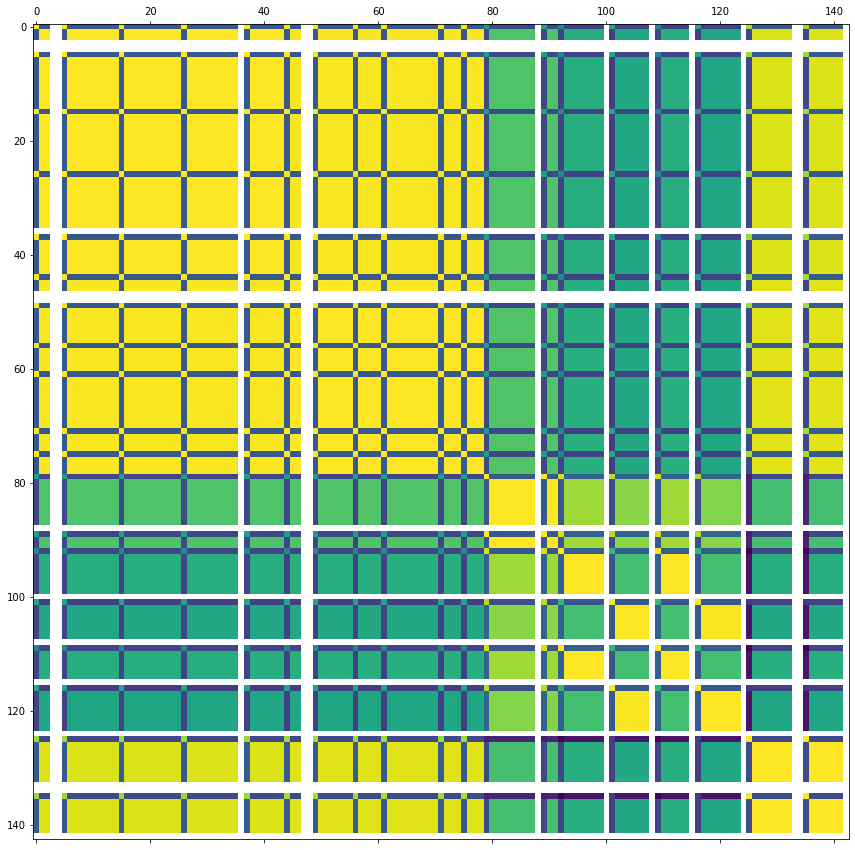

In [122]:
#df_DP04_PE.corr(method ='pearson')

#plt.matshow(df_DP04_PE.corr())
#plt.show()

fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(df_DP04_PE.drop('index', axis=1).corr())

In [85]:
# create simple figs

# ax = df_hb.plot.barh(x='index', y='DP02_0001E+Estimate!!HOUSEHOLDS BY TYPE!!Total households', figsize=(100,900))

df = px.data.iris() # iris is a pandas DataFrame
fig = px.scatter(df_DP04,
                 x='DP04_0001PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units',
                 y='DP04_0002PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
                 size='DP04_0001E+Estimate!!HOUSING OCCUPANCY!!Total housing units',
                 color='locale')
fig.show()

#fig = px.scatter(x=df_hb.iloc[:,1], y=df_hb.iloc[:,3])
#fig.show()

In [100]:
# snips
"""


print(list(set(['a','b','c','d'])-set(['a','b'])))


#list(df_hb_DP04.columns)
#df_hillsborough_acs5['index']
#pd.concat([df_hillsborough_acs5['index'] , df_hillsborough_acs5.rename(columns=data_dict).filter(regex='DP04')])


#df_data_dict_DP004 = df_data_dict[df_data_dict['variable_cat'].str.match('DP04')]
#df_data_dict['variable_cat'] = df_data_dict['variable'].str.split('_', expand=True)[0]


json_hillsborough_evict = df_hillsborough_county_evictions_geocoded.to_json(orient="split")
hb_parsed = json.loads(json_hillsborough_evict)

with open('json_hillsborough_evict.json', 'w') as json_file:
    json.dump(hb_parsed, json_file)
"""

['c', 'd']


'\n\n#list(df_hb_DP04.columns)\n#df_hillsborough_acs5[\'index\']\n#pd.concat([df_hillsborough_acs5[\'index\'] , df_hillsborough_acs5.rename(columns=data_dict).filter(regex=\'DP04\')])\n\n\n#df_data_dict_DP004 = df_data_dict[df_data_dict[\'variable_cat\'].str.match(\'DP04\')]\n#df_data_dict[\'variable_cat\'] = df_data_dict[\'variable\'].str.split(\'_\', expand=True)[0]\n\n\njson_hillsborough_evict = df_hillsborough_county_evictions_geocoded.to_json(orient="split")\nhb_parsed = json.loads(json_hillsborough_evict)\n\nwith open(\'json_hillsborough_evict.json\', \'w\') as json_file:\n    json.dump(hb_parsed, json_file)\n'